## Data Visualizations and Analysis

Available datasets:
- Realised_Supply_Germany.csv
- Realised_Demand_Germany.csv
- Weather_Data_Germany.csv

### Realised Supply Germany

In [63]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from enum import Enum
from pathlib import Path

sys.path.append(str(Path("..").resolve()))
from src.visualizations import setup_tueplots, plot_wind_power_composition

In [64]:
path = Path('..') / 'data' / 'Realised_Supply_Germany.csv'
df = pd.read_csv(path, sep=';', decimal=',')

df.head()

,Date from,Date to,Biomass [MW],Hydro Power [MW],Wind Offshore [MW],Wind Onshore [MW],Solar Power [MW],Other Renewable [MW],Nuclear Power [MW],Lignite [MW],Coal [MW],Natural Gas [MW],Pumped Storage [MW],Other Conventional [MW]
0,01.01.19 00:00,01.01.19 00:15,"1.199,00",401.00,"794,25","4.839,25",0,31.5,"2.250,50","1.733,00","836,25","850,5","87,5",431.75
1,01.01.19 00:15,01.01.19 00:30,"1.203,00",394.75,"793,5","5.030,75",0,31.5,"2.263,25","1.587,75","729,5","821,5","99,25",429.75
2,01.01.19 00:30,01.01.19 00:45,"1.204,50",381.25,"791,75","5.213,50",0,31.5,"2.246,00","1.555,25","648,5","804,75",44,431.25
3,01.01.19 00:45,01.01.19 01:00,"1.208,75",381.00,"754,5","5.308,25",0,31.5,"2.241,75","1.459,00","597,5","796,5",41,431.50
4,01.01.19 01:00,01.01.19 01:15,"1.204,50",388.25,"715,5","5.398,50",0,31.5,"2.224,50","1.367,75","610,5","765,5",21,429.25


In [65]:
df.columns

Index(['Date from', 'Date to', 'Biomass [MW]', 'Hydro Power [MW]',
       'Wind Offshore [MW] ', 'Wind Onshore [MW]', 'Solar Power [MW]',
       'Other Renewable [MW]', 'Nuclear Power [MW]', 'Lignite [MW]',
       'Coal [MW]', 'Natural Gas [MW]', 'Pumped Storage [MW]',
       'Other Conventional [MW]'],
      dtype='object')

In [66]:
class Column(Enum):
    DATE_FROM = "Date from"
    DATE_TO = "Date to"
    WIND_OFFSHORE = "Wind Offshore [MW] "
    WIND_ONSHORE = "Wind Onshore [MW]"
    WIND = "Wind Sum [MW]"


**Transform data intervals into datetime objects**

In [67]:
df[Column.DATE_FROM.value] = pd.to_datetime(
    df[Column.DATE_FROM.value], format="%d.%m.%y %H:%M"
)
df[Column.DATE_TO.value] = pd.to_datetime(
    df[Column.DATE_TO.value], format="%d.%m.%y %H:%M"
)
df.set_index(Column.DATE_FROM.value, inplace=True)
df.sort_index(inplace=True)

**Transform columns into the correct float representation**

In [68]:
# Columns to exclude from numeric conversion
non_numeric_cols = [Column.DATE_FROM.value, Column.DATE_TO.value]

# Convert relevant columns
for col in df.columns:
    if col not in non_numeric_cols:
        df[col] = df[col].astype(str).str.replace(".", "", regex=False).str.replace(",", ".", regex=False)
        df[col] = pd.to_numeric(df[col], errors="coerce") # error handling --> NaN


In [69]:
# 15 minutes intervals summed up to 1 hour intervals
df = df.resample("h").sum(numeric_only=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35064 entries, 2019-01-01 00:00:00 to 2022-12-31 23:00:00
Freq: h
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Biomass [MW]             35064 non-null  float64
 1   Hydro Power [MW]         35064 non-null  int64  
 2   Wind Offshore [MW]       35064 non-null  float64
 3   Wind Onshore [MW]        35064 non-null  float64
 4   Solar Power [MW]         35064 non-null  float64
 5   Other Renewable [MW]     35064 non-null  int64  
 6   Nuclear Power [MW]       35064 non-null  float64
 7   Lignite [MW]             35064 non-null  float64
 8   Coal [MW]                35064 non-null  float64
 9   Natural Gas [MW]         35064 non-null  float64
 10  Pumped Storage [MW]      35064 non-null  float64
 11  Other Conventional [MW]  35064 non-null  int64  
dtypes: float64(9), int64(3)
memory usage: 3.5 MB


In [70]:
# Calculate the sum of Wind Offshore and Wind Onshore
df[Column.WIND.value] = df[Column.WIND_OFFSHORE.value] + df[Column.WIND_ONSHORE.value]

In [71]:
dates = df.index
wind_offshore = df[Column.WIND_OFFSHORE.value]
wind_onshore = df[Column.WIND_ONSHORE.value]
wind = df[Column.WIND.value]

wind_offshore_mean = wind_offshore.copy().rolling(window=24*7*4).mean()
wind_mean = wind.copy().rolling(window=24*7*4).mean()

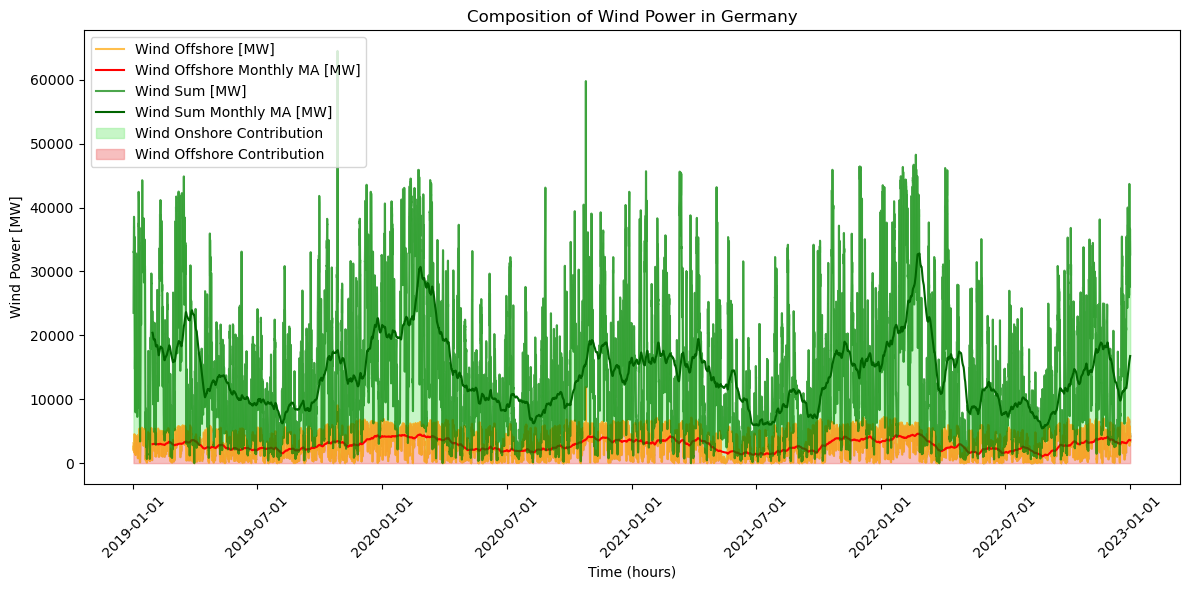

In [72]:
# setup_tueplots()

fig, ax = plt.subplots(figsize=(12, 6))
locator = ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(locator=locator))

ax.plot(dates, wind_offshore, label="Wind Offshore [MW]", color="orange", alpha=0.7)
ax.plot(dates, wind_offshore_mean, label="Wind Offshore Monthly MA [MW]", color="red", alpha=1)
ax.plot(dates, wind, label="Wind Sum [MW]", color="green", alpha=0.7)
ax.plot(dates, wind_mean, label="Wind Sum Monthly MA [MW]", color="darkgreen", alpha=1)
ax.fill_between(dates, wind_offshore, wind, color="lightgreen", alpha=0.5, label="Wind Onshore Contribution")
ax.fill_between(dates, 0, wind_offshore, color="lightcoral", alpha=0.5, label="Wind Offshore Contribution")

ax.set_title("Composition of Wind Power in Germany")
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Wind Power [MW]")
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

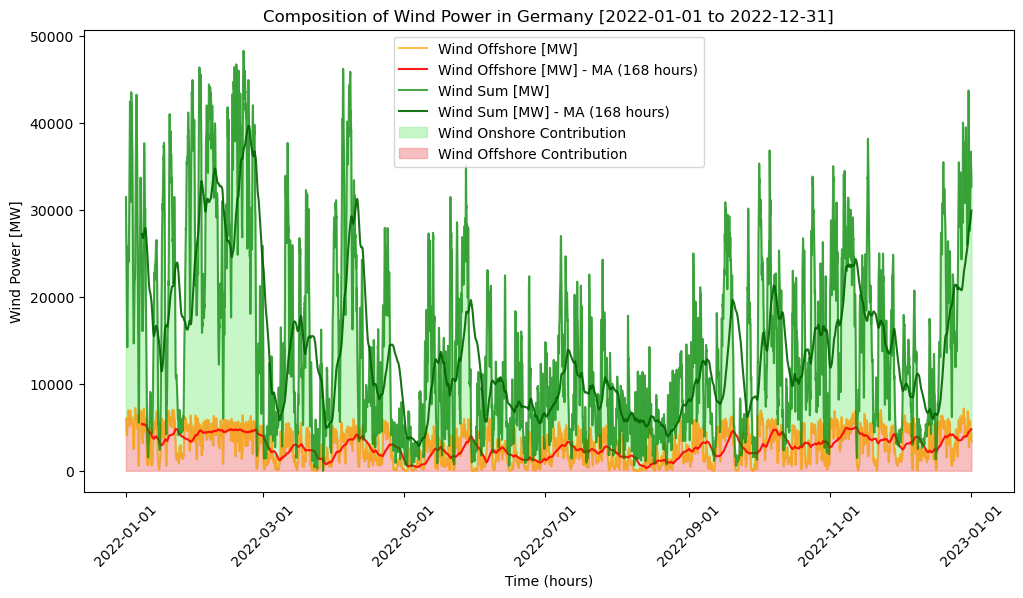

In [73]:
# df_indexed = df["2022-01-01":"2022-12-31"]
df_indexed = df["2022-01-01":"2023-01-01"]
wind_offshore_2022 = df_indexed[Column.WIND_OFFSHORE.value]
wind_onshore_2022 = df_indexed[Column.WIND_ONSHORE.value]
dates_2022 = df_indexed.index

fig = plot_wind_power_composition(
    dates_2022, wind_offshore_2022, wind_onshore_2022, 24*7,
)

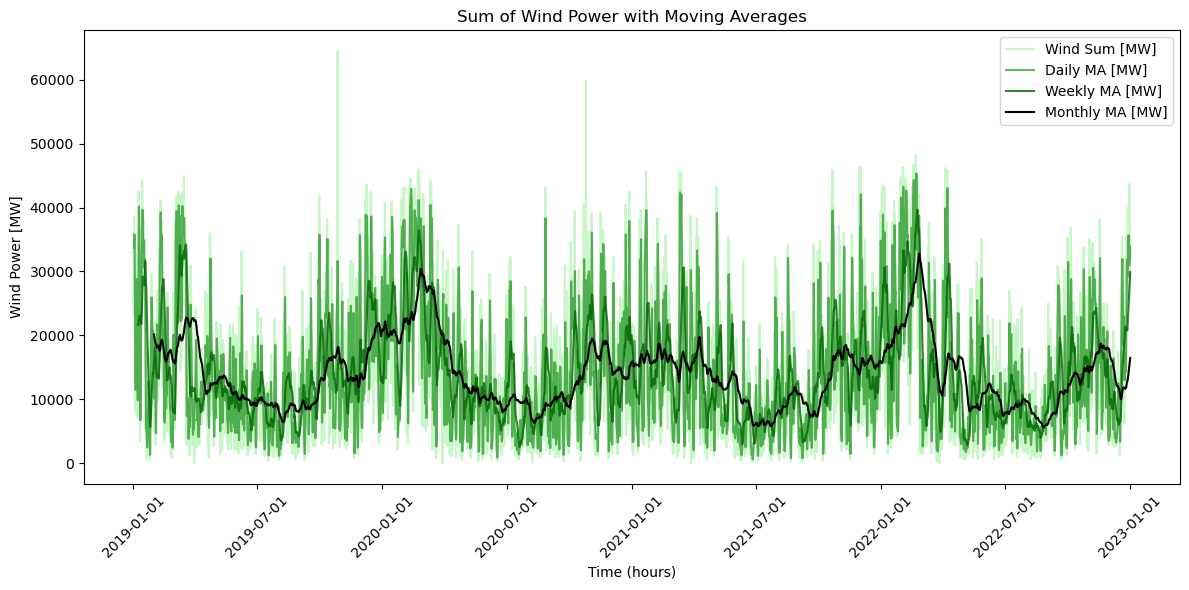

In [74]:
# Calculate moving averages
wind_daily_ma = wind.rolling(window=24).mean()
wind_weekly_ma = wind.rolling(window=24*7).mean()
wind_monthly_ma = wind.rolling(window=24*30).mean()

# Plot the data
fig, ax = plt.subplots(figsize=(12, 6))
locator = ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(locator=locator))

ax.plot(dates, wind, label="Wind Sum [MW]", color="lightgreen", alpha=0.5)
ax.plot(dates, wind_daily_ma, label="Daily MA [MW]", color="green", alpha=0.6)
ax.plot(dates, wind_weekly_ma, label="Weekly MA [MW]", color="darkgreen", alpha=0.8)
ax.plot(dates, wind_monthly_ma, label="Monthly MA [MW]", color="black", alpha=1)

ax.set_title("Sum of Wind Power with Moving Averages")
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Wind Power [MW]")
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Weather Data Germany

In [75]:
from src.preprocessing import weather_germany_mean, weather_germany_clustered

In [76]:
weather_path = Path('..') / "data" / "Weather_Data_Germany.csv"
weather = pd.read_csv(weather_path, sep=',', decimal='.')

weather.head(2)

,longitude,latitude,forecast_origin,time,cdir,z,msl,blh,tcc,u10,v10,t2m,ssr,tsr,sund,tp,fsr,u100,v100
0,5.8,54.2,2019-01-01 00:00:00,2019-01-01 00:00:00,0.0,-2.766602,102439.914,766.03015,0.304399,11.806978,2.823900,282.04110,0.0,0.0,0.0,0.0,0.000860,15.666069,3.153420
1,5.8,53.2,2019-01-01 00:00:00,2019-01-01 00:00:00,0.0,-6.159180,102795.230,842.93190,0.945699,6.628730,1.767059,281.28223,0.0,0.0,0.0,0.0,0.254992,10.824787,2.401394


In [77]:
weather["forecast_origin"] = pd.to_datetime(
    weather["forecast_origin"], format="%Y-%m-%d %H:%M:%S"
)
weather["time"] = pd.to_datetime(weather["time"], format="%Y-%m-%d %H:%M:%S")
weather.set_index("time", inplace=True)
weather.sort_index(inplace=True)
weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2104320 entries, 2019-01-01 00:00:00 to 2021-12-31 23:00:00
Data columns (total 18 columns):
 #   Column           Dtype         
---  ------           -----         
 0   longitude        float64       
 1   latitude         float64       
 2   forecast_origin  datetime64[ns]
 3   cdir             float64       
 4   z                float64       
 5   msl              float64       
 6   blh              float64       
 7   tcc              float64       
 8   u10              float64       
 9   v10              float64       
 10  t2m              float64       
 11  ssr              float64       
 12  tsr              float64       
 13  sund             float64       
 14  tp               float64       
 15  fsr              float64       
 16  u100             float64       
 17  v100             float64       
dtypes: datetime64[ns](1), float64(17)
memory usage: 305.0 MB


In [78]:
# Select preprocessing method:
# 1. mean weather data across Germany
# 2. cluesterd mean weather data (keep parts of location information)

k_clusters = 5
use_clustering = False

if use_clustering:
    weather = weather_germany_clustered(weather, k_clusters=k_clusters)
else:
    weather = weather_germany_mean(weather)

weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26304 entries, 2019-01-01 00:00:00 to 2021-12-31 23:00:00
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   cdir    26304 non-null  float64
 1   z       26304 non-null  float64
 2   msl     26304 non-null  float64
 3   blh     26304 non-null  float64
 4   tcc     26304 non-null  float64
 5   u10     26304 non-null  float64
 6   v10     26304 non-null  float64
 7   t2m     26304 non-null  float64
 8   ssr     26304 non-null  float64
 9   tsr     26304 non-null  float64
 10  sund    26304 non-null  float64
 11  tp      26304 non-null  float64
 12  fsr     26304 non-null  float64
 13  u100    26304 non-null  float64
 14  v100    26304 non-null  float64
dtypes: float64(15)
memory usage: 3.2 MB


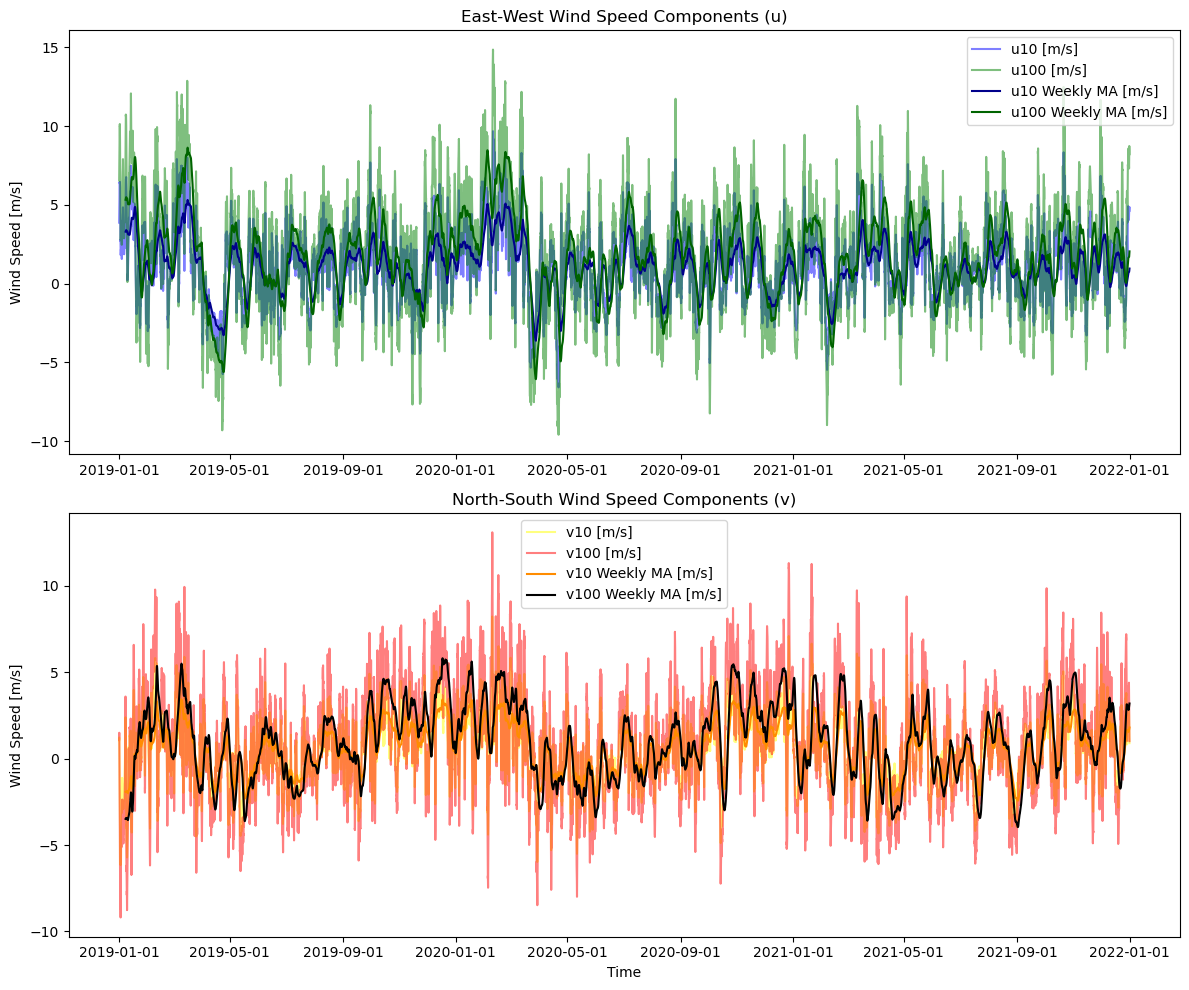

In [79]:
u10 = weather["u10"]
u100 = weather["u100"]
v10 = weather["v10"]
v100 = weather["v100"]

# Plot the data
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
locator1 = ax1.xaxis.set_major_locator(mdates.AutoDateLocator())
ax1.xaxis.set_major_formatter(mdates.AutoDateFormatter(locator1))
locator2 = ax2.xaxis.set_major_locator(mdates.AutoDateLocator())
ax2.xaxis.set_major_formatter(mdates.AutoDateFormatter(locator2))

# Plot first subplot - u components
ax1.plot(weather.index, u10, label="u10 [m/s]", color="blue", alpha=0.5)
ax1.plot(weather.index, u100, label="u100 [m/s]", color="green", alpha=0.5)
ax1.plot(weather.index, u10.rolling(window=24*7).mean(), label="u10 Weekly MA [m/s]", color="darkblue", alpha=1)
ax1.plot(weather.index, u100.rolling(window=24*7).mean(), label="u100 Weekly MA [m/s]", color="darkgreen", alpha=1)
ax1.set_title("East-West Wind Speed Components (u)")
ax1.set_ylabel("Wind Speed [m/s]")
ax1.legend()

# Plot second subplot - v components
ax2.plot(weather.index, v10, label="v10 [m/s]", color="yellow", alpha=0.5)
ax2.plot(weather.index, v100, label="v100 [m/s]", color="red", alpha=0.5)
ax2.plot(weather.index, v10.rolling(window=24*7).mean(), label="v10 Weekly MA [m/s]", color="darkorange", alpha=1)
ax2.plot(weather.index, v100.rolling(window=24*7).mean(), label="v100 Weekly MA [m/s]", color="black", alpha=1)
ax2.set_title("North-South Wind Speed Components (v)")
ax2.set_xlabel("Time")
ax2.set_ylabel("Wind Speed [m/s]")
ax2.legend()

plt.tight_layout()
plt.show()

### Machine Learning Setup for Forecasting
- Split data into training and testing sets
- Sliding window approach for time series forecasting
- Feature engineering
   - Create lag features
   - Use weather data as additional features
- Feature selection
   - Select relevant features based on correlation with target variable
   - 1. Mutual Information, Pearson Correlation
   - 2. Fit a Lasso regression model and select features based on coefficients (try LassoCV)
- Gaussian Process Regression Model Training
   - Train a Gaussian Process Regression model using the selected feature on the training set
   - Use the model to make predictions on the test set
   - Evaluate at different time horizons (e.g., 1 hour, 2 hours, etc.) using RMSE and CRPS
- Hyperparameter tuning
   - Use cross-validation to tune hyperparameters of the Gaussian Process Regression model
   - Use GridSearchCV or RandomizedSearchCV for hyperparameter tuning

In [ ]:
# Relevant columns for the model
target = [Column.WIND.value]
df = df[target].copy()

# Split the data into training and test sets
split_date = "2022-01-01"
train_data = df[df.index < split_date]

# Add weather data to the training set
train_data = train_data.join(weather, how="inner")
train_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26304 entries, 2019-01-01 00:00:00 to 2021-12-31 23:00:00
Freq: h
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Wind Sum [MW]  26304 non-null  float64
 1   cdir           26304 non-null  float64
 2   z              26304 non-null  float64
 3   msl            26304 non-null  float64
 4   blh            26304 non-null  float64
 5   tcc            26304 non-null  float64
 6   u10            26304 non-null  float64
 7   v10            26304 non-null  float64
 8   t2m            26304 non-null  float64
 9   ssr            26304 non-null  float64
 10  tsr            26304 non-null  float64
 11  sund           26304 non-null  float64
 12  tp             26304 non-null  float64
 13  fsr            26304 non-null  float64
 14  u100           26304 non-null  float64
 15  v100           26304 non-null  float64
dtypes: float64(16)
memory usage: 3.4 MB


In [81]:
# Test data
test_data = df[df.index >= split_date]
test_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2022-01-01 00:00:00 to 2022-12-31 23:00:00
Freq: h
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Wind Sum [MW]  8760 non-null   float64
dtypes: float64(1)
memory usage: 136.9 KB


In [84]:
# Create a function to generate the training and test sets
def create_sliding_window_data(data: pd.DataFrame, history: int, forecast_horizon: int):
    X, y = [], []
    for i in range(len(data) - history - forecast_horizon + 1):
        history_data = data.iloc[i : i + history].values
        future_data = data.iloc[i + history : i + history + forecast_horizon][
            Column.WIND.value
            ].values
        X.append(history_data)
        y.append(future_data)
    return np.array(X), np.array(y)


In [85]:
# Sliding window training
horizon = 24 # 24 hours
history = 24 * 7 # 168 hours = 7 days (lag features)

train_data = train_data.copy()
test_data = test_data.copy()
# train_data["target"] = train_data[Column.WIND.value].shift(-horizon)

X, y = create_sliding_window_data(
    train_data, history=history, forecast_horizon=horizon
)
X_test, y_test = create_sliding_window_data(
    test_data, history=history, forecast_horizon=horizon
)
X.shape, y.shape, X_test.shape, y_test.shape


((26113, 168, 16), (26113, 24), (8569, 168, 1), (8569, 24))